# Event Analysis
This notebooke analyses the surface event data 10/10/22 fskene@uw.edu

In [1]:
# import modules
import matplotlib.pyplot as plt
from matplotlib.pyplot import Figure
import numpy as np
import pandas as pd
import obspy
from obspy.core import UTCDateTime
from obspy.clients.fdsn.client import Client
from obspy.geodetics import *
from obspy.core.utcdatetime import UTCDateTime
import requests
from mpl_toolkits.axes_grid1 import make_axes_locatable
from geopy import distance
import datetime
import rasterio as rio
from rasterio.plot import show
from rasterio.merge import merge
import richdem as rd
from pathlib import Path
import os 
import glob
from scipy.stats import norm
import sys
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from pyproj import Proj,transform,Geod
from matplotlib.lines import Line2D

In [2]:
# establish parameters
window = 30 #window length of the signal
thr = 12 #SNR threshold
station_distance_threshold = 25
pi = np.pi
v_s = 1000 #shear wave velocity at the surface
colors = list(plt.cm.tab10(np.arange(10)))*3
radius = 6371e3
ratio = 5.6915196


In [3]:
# define functions
def volc_loc_thr(left_lat, bottom_lon, sidelength):
    d = distance.geodesic(meters = sidelength)
    right_lat = d.destination(point=[left_lat,bottom_lon], bearing=0)[0]
    top_lon = d.destination(point=[left_lat,bottom_lon], bearing=90)[1]
    return right_lat, top_lon

def start_latlon(elevation, ratio, center_lat, center_lon):
    side_length = elevation * ratio
    l = side_length/2
    hypotenuse = l*np.sqrt(2)
    d = distance.geodesic(meters = hypotenuse)
    start_lat = d.destination(point=[center_lat,center_lon], bearing=225)[0]
    start_lon = d.destination(point=[center_lat,center_lon], bearing=225)[1]
    return start_lat, start_lon, side_length

In [4]:
# Read in and organize location data
Event_Data = pd.read_csv("Analysis_Data/Event_Data_10_24.csv")
new_list = [np.nan]*(len(Event_Data))
Event_Data['Label'] = new_list

In [ ]:
# read xcel file with ground truth events (from Wes)
inputExcelFile ="surfaceFlows_cloud.xlsx"
# Reading an excel file
excelFile = pd.read_excel (inputExcelFile)
# Converting excel file into CSV file
excelFile.to_csv ("ResultCsvFile.csv", index = None, header=True)
# Reading and Converting the output csv file into a dataframe object
known_events = pd.DataFrame(pd.read_csv("ResultCsvFile.csv"))
starttimes = []
for i in range(len(known_events['Date'])):
    try:
        time = known_events['Time Start'][i].split(':')
        if time[1][0] == '0':
            time[1] = time[1][1]
        if time[2][0] == '0':
            time[2] = time[2][1]
        date = known_events['Date'][i].split('-')
        if date[1][0] == '0':
            date[1] = date[1][1]
        if date[2][0] == '0':
            date[2] = date[2][1]
        starttimes.append(UTCDateTime(int(date[0]),int(date[1]),int(date[2]),int(time[0])))#,int(time[1])))#,int(time[2])))
    except:
        continue   

In [6]:
# Volcano location data
volc_lat_lon = {}
volc_lat_lon['Mt_Rainier'] = [46.8528857, -121.7603744, 4392.5, 10000, 3000, 15000, 7000]
volc_lat_lon['Mt_Adams'] = [46.202621, -121.4906384, 3743.2, 5000, 3000, 4000, 2000]
volc_lat_lon['Mt_Baker'] = [48.7773426,  -121.8132008, 3287.6, 0, 0, 0, 2000]
volc_lat_lon['Mt_St_Helens'] =[46.200472222222224,-122.18883611111112,2549, 10000, 10000, 17000, 15000] #[46.1912, -122.1944, 2549]
volc_lat_lon['Glacier_Peak'] = [48.1112273, -121.1139922, 3213, 14000, 10000, 8000, 10000]
volc_lat_lon['Crater_Lake']=[42.907745, -122.143494, 1883, 60000, 0, 90000, 0]
volc_lat_lon['Mt_Hood']=[45.373221, -121.696509, 3428.7, 18000, 50000, 35000, 65000]
volc_lat_lon['Newberry']=[43.7220653, -121.2344654, 2435, 53000, 12000, 70000, 20000]

In [7]:
#DEM data 
dem_data_dict = {}
for name in volc_lat_lon:
    if volc_lat_lon[name][0]>46:
        dem = rio.open('Data/DEM_data/'+str(name)+'/'+str(name)+'.tif') #washington volcanoes
        dem_array = dem.read(1).astype('float64')
        dem_array[dem_array == -32767] = np.nan #gets rid of edge effects
        crs = dem.crs
    else:
        dem = rio.open('Data/DEM_data/'+str(name)+'/_w001001.adf') #oregon volcanoes
        dem_array = dem.read(1).astype('float64')
        dem_array[dem_array == -3.4028234663852886e+38] = np.nan #gets rid of edge effects
        crs = dem.crs
#     volc = rd.rdarray(dem_array, no_data=-9999)
#     slope = rd.TerrainAttribute(volc,attrib = 'slope_riserun')
#     aspect = rd.TerrainAttribute(volc, attrib = 'aspect')
#     dem_data_dict[name] = {'data':dem_array, 'elevation':volc, 'slope':slope, 'aspect':aspect}
    dem_data_dict[name]={'data':dem_array, 'crs':crs, 'left':dem.bounds[0], 'right':dem.bounds[2], 'bottom':dem.bounds[1], 'top':dem.bounds[3]}

In [8]:
# Find the lower left corner and grid size based on volcano elevation
volc_grid = {}
for volc in volc_lat_lon:
    elevation = volc_lat_lon[volc][2]
    center_lat = volc_lat_lon[volc][0]
    center_lon = volc_lat_lon[volc][1]
    left_lat, bottom_lon, sidelength = start_latlon(elevation, ratio, center_lat, center_lon)
    right_lat, top_lon = volc_loc_thr(left_lat, bottom_lon, sidelength)
    volc_grid[volc] = [left_lat, right_lat, bottom_lon, top_lon, sidelength]

## Add Ground truth labels from Wes' Catalog

In [ ]:
# 33 events on Mt Rainier had labels
times = list(Event_Data['origin_time'])
temp = []
for i in times:
    a = UTCDateTime(i).strftime("%Y-%m-%d, %H")
    temp.append(UTCDateTime(a))
overlaps = []
temp2 = []
for i in range(len(starttimes)):
    if starttimes[i] in temp:
        overlaps.append(starttimes[i])
        temp2.append(known_events['Remarks'][i])
        print(starttimes[i],known_events['Remarks'][i])
for i in range(len(temp)):
    for j in temp2:
        if temp[i] in overlaps:
            Event_Data['Label'][i]= j
display(Event_Data.iloc[30:60])

# Histogram of frequencies at each station

In [143]:
freq_data = pd.read_csv('Analysis_Data/Station_frequency_data_10_24.csv') 
sta_freq = {}
for i in freq_data.columns:
    df2=freq_data.dropna(subset=[i])
    med_freq = np.median(df2[i])
    if med_freq>0:
        sta_freq[i] = med_freq


/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jupyter_share/miniconda3/envs

/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jupyter_share/miniconda3/envs

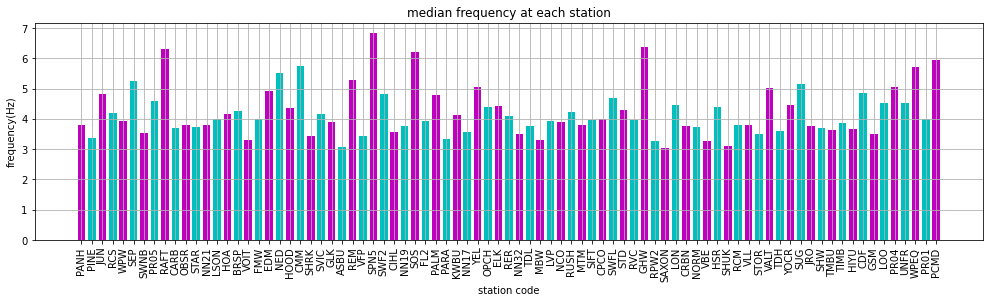

In [145]:
fig = plt.figure(figsize = (17,4))
plt.title('median frequency at each station')
plt.bar(np.linspace(0,90,len(sta_freq)), sta_freq.values(), color=(['m','c']*41)+['m'],tick_label = list(sta_freq.keys()))
plt.xticks(rotation=90)
plt.ylabel('frequency(Hz)')
plt.xlabel('station code')
plt.grid('True')

## Scatterplot of event locations + Histograms of Velocities on each Volcano

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.606653

A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

/tmp/ipykernel_777311/782682219.py:60: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  left_x,bottom_y = transform(p1,p2,volc_grid[associated_volcano][1],volc_grid[associated_volcano][0]) # p1,p2,lon,lat
[======        

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


/tmp/ipykernel_777311/782682219.py:65: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  center_x, center_y = transform(p1,p2,info[1],info[0])
t Wall-time = 0.279877======================= ] (99% - 0.0s - 1 threads)
/tmp/ipykernel_777311/782682219.py:80: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  loc_lon,loc_lat = transform(p1,p2,lons[i],lats[i])


Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.618584

A 

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

[=====        /tmp/ipykernel_777311/782682219.py:60: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  left_x,bottom_y = transform(p1,p2,volc_grid[associated_volcano][1],volc_grid[associated_volcano][0]) # p1,p2,lon,lat
/tmp/ipykernel_777311/782682219.py:65: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  center_x, center_y = transform(p1,p2,info[1],info[0])
t Wall-time = 0.285182


/tmp/ipykernel_777311/782682219.py:80: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  loc_lon,loc_lat = transform(p1,p2,lons[i],lats[i])


Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 4.71743


Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

/tmp/ipykernel_777311/782682219.py:60: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  left_x,bottom_y = transform(p1,p2,volc_grid[associated_volcano][1],volc_grid[associated_volcano][0]) # p1,p2,lon,lat
[======        /tmp/ipykernel_777311/782682219.py:65: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  center_x, center_y = transform(p1,p2,info[1],info[0])
t Wall-time = 2.133


/tmp/ipykernel_777311/782682219.py:80: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  loc_lon,loc_lat = transform(p1,p2,lons[i],lats[i])


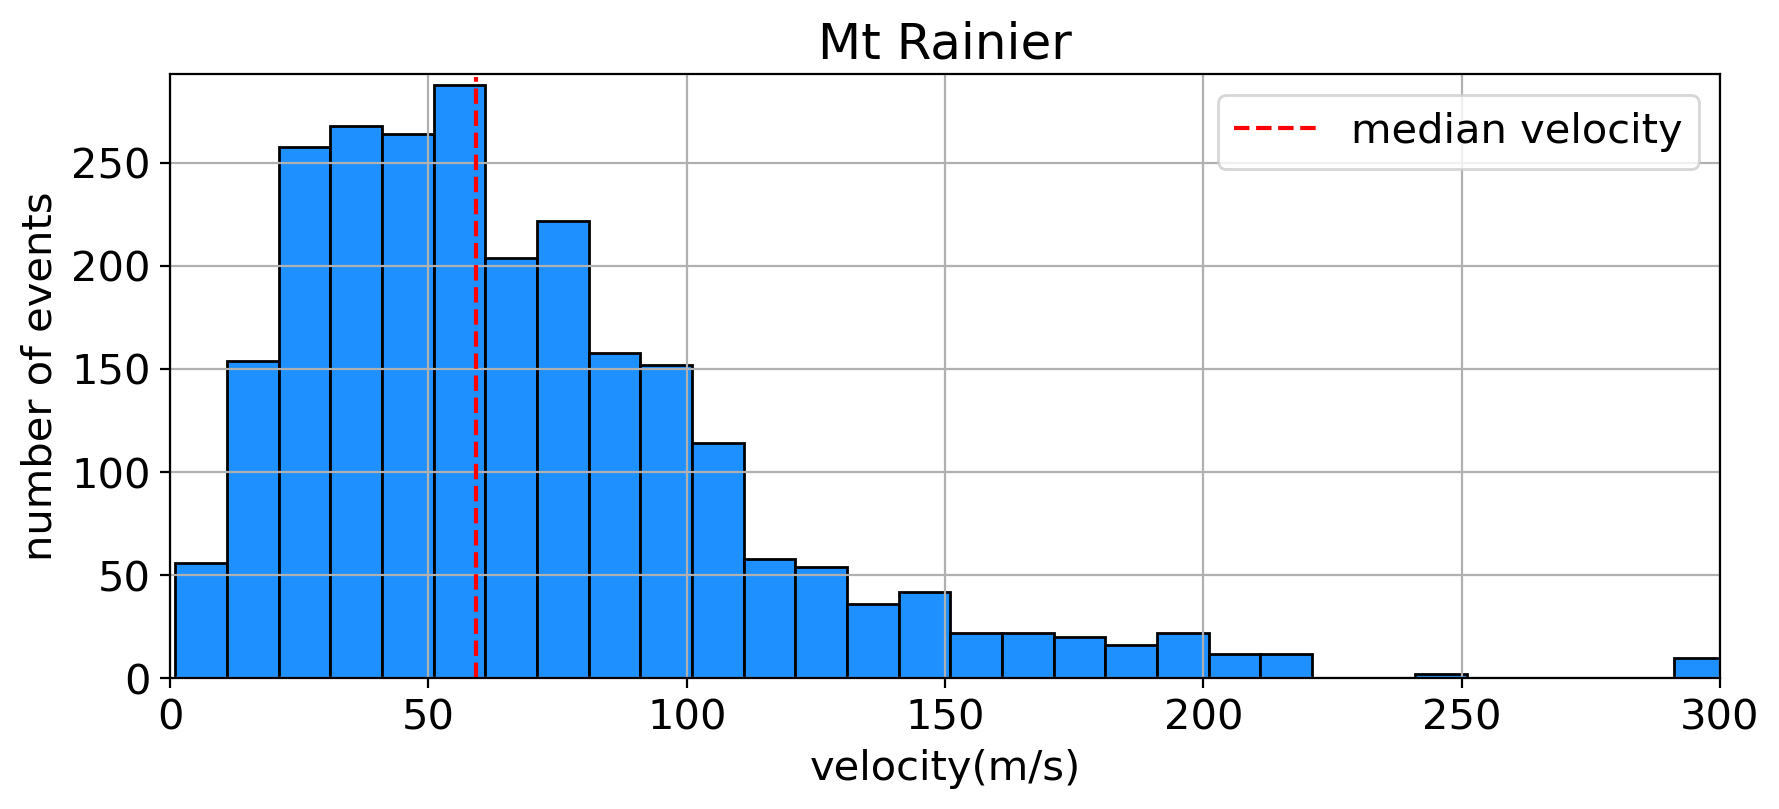

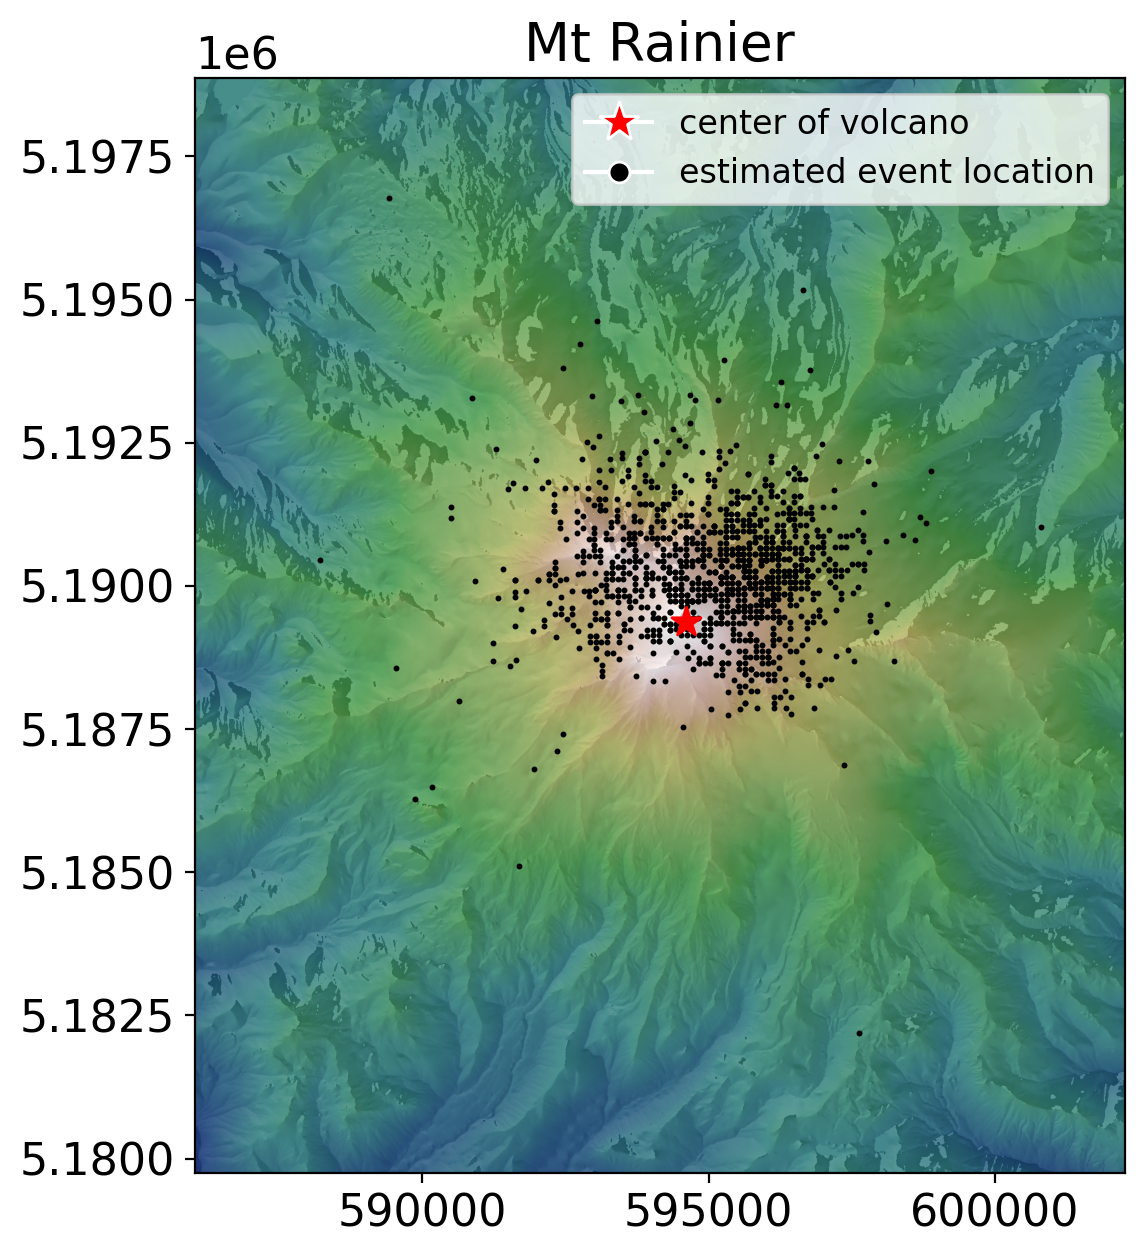

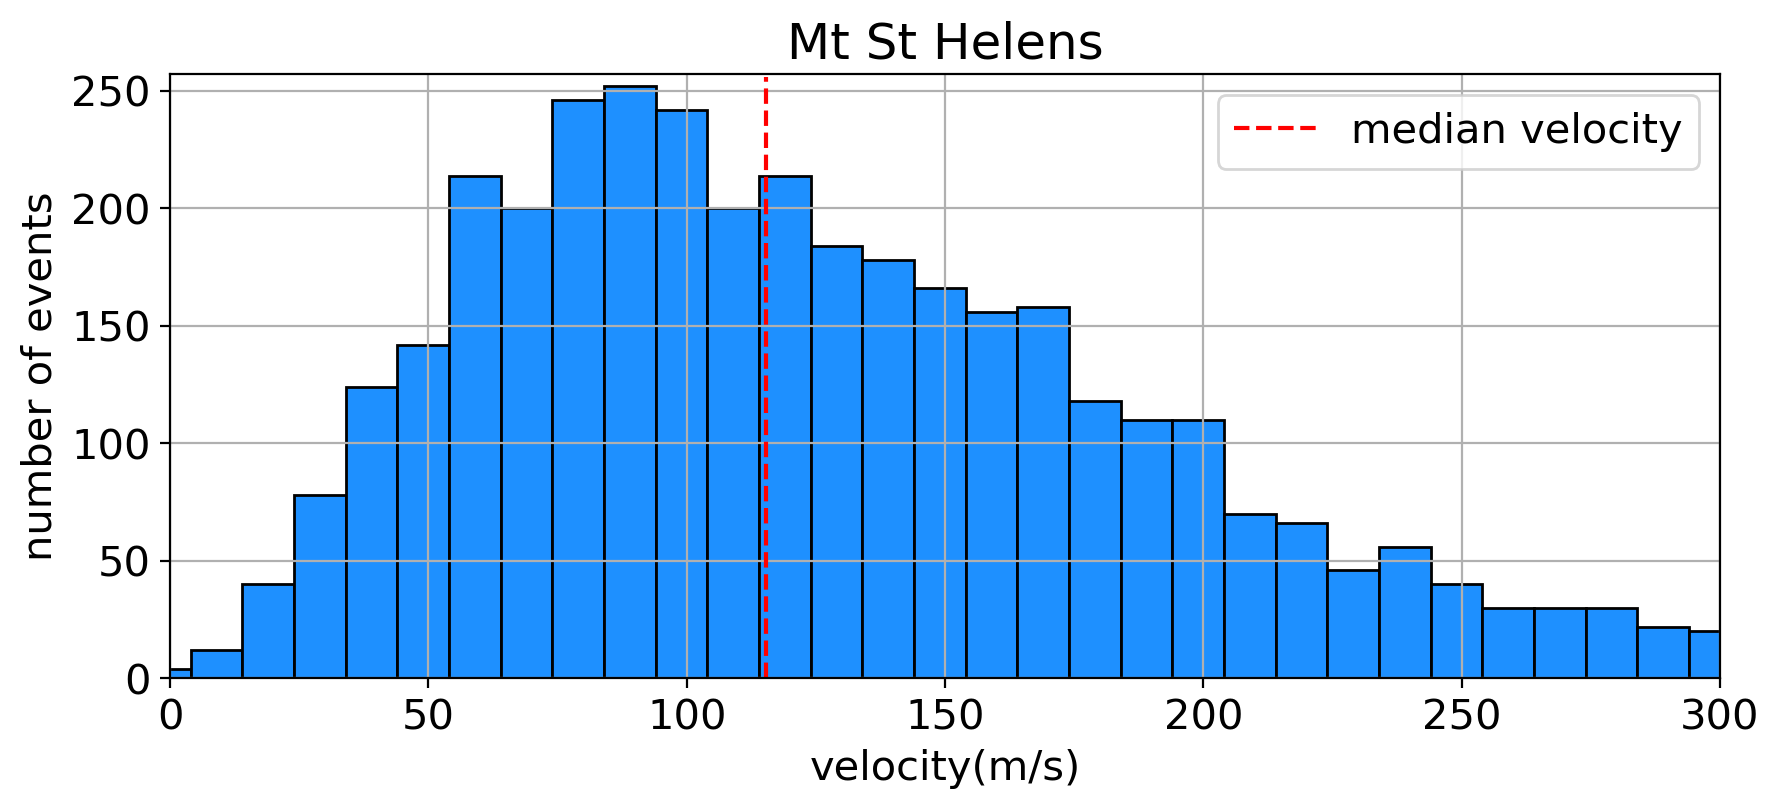

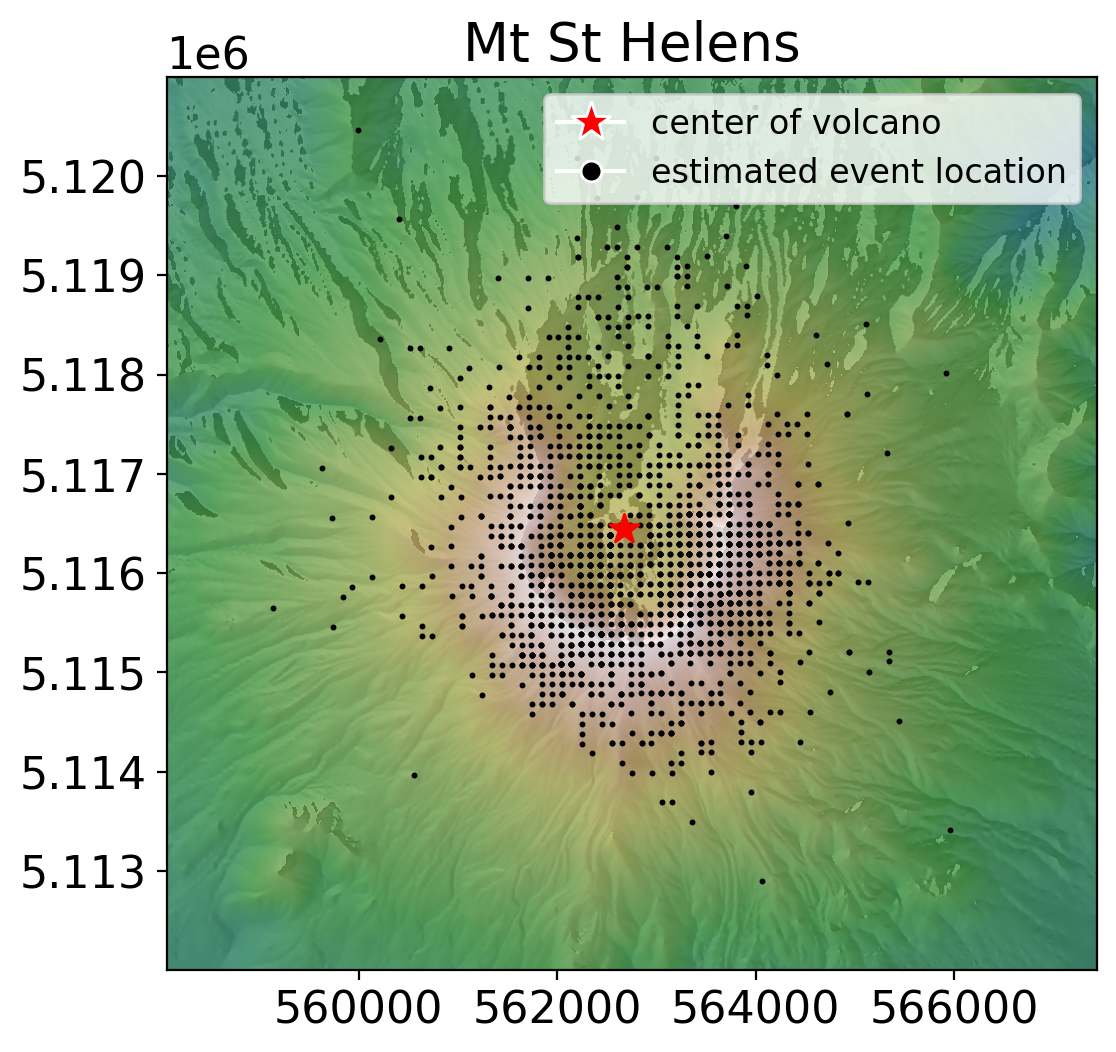

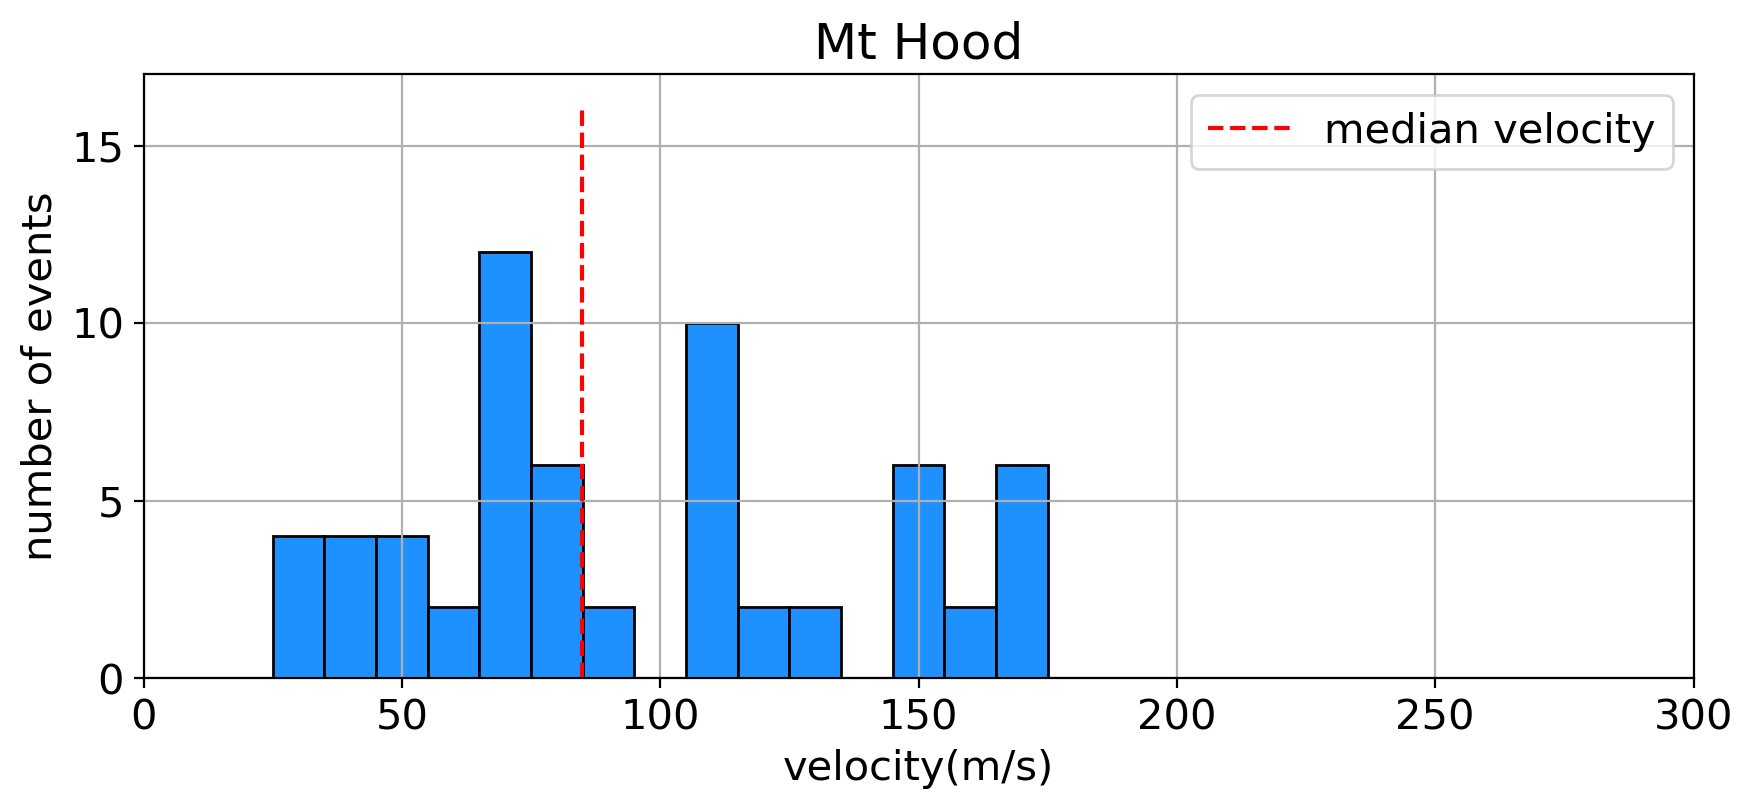

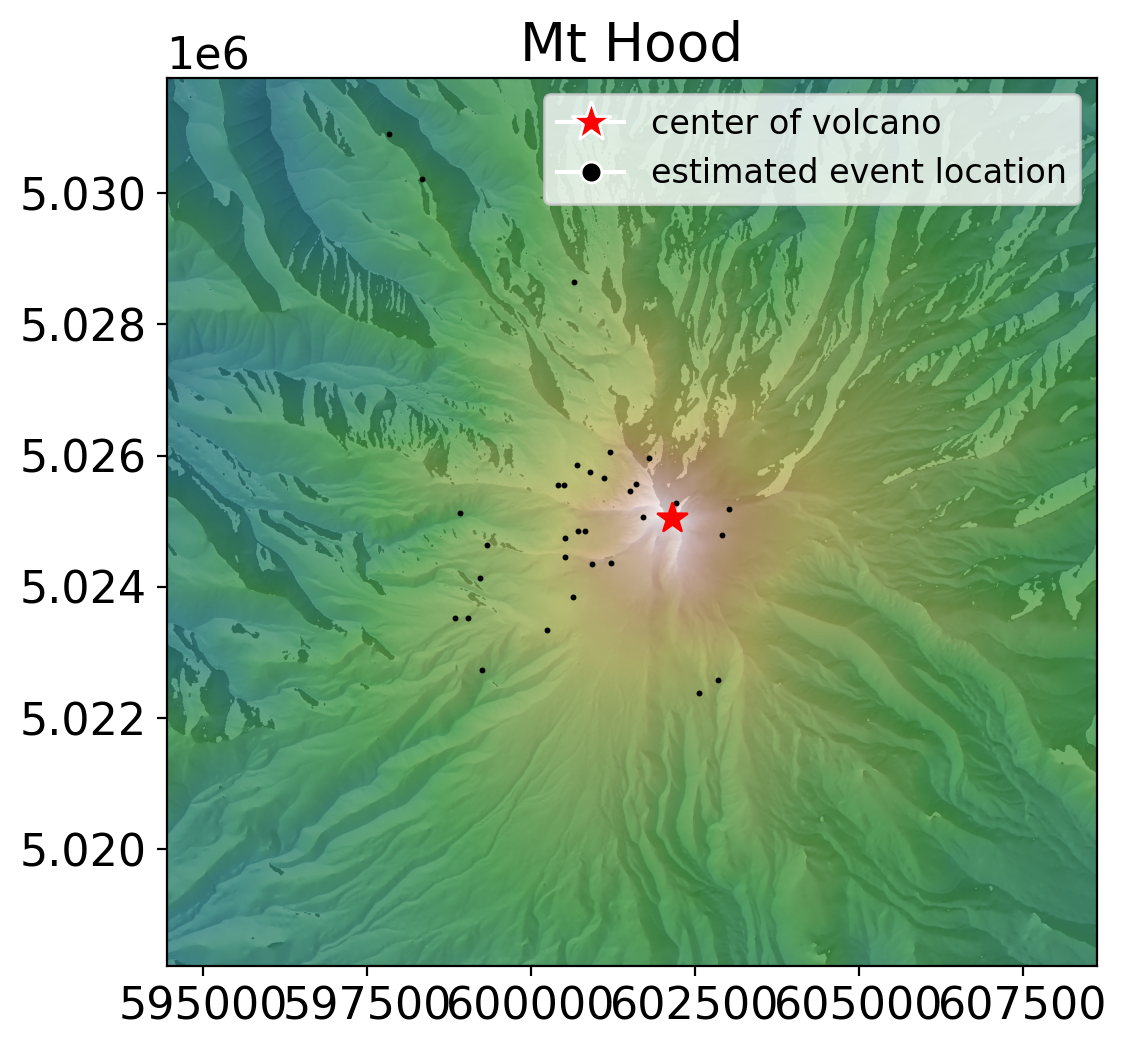

In [10]:
mtn_list = ['Mt_Rainier','Mt_St_Helens','Mt_Hood']
for n in mtn_list:
    lats = []
    lons = []
    vel = []
    evt_id = []
    dir_snr = []
    dir_sharp = []
    direc = []
    sharp = []
    vel = []
    times = []
    new_vel = []
    for i in range(len(Event_Data)):
        if volc_grid[n][0]<Event_Data['location_latitude'][i]<volc_grid[n][1] and volc_grid[n][2]<Event_Data['location_longitude'][i]<volc_grid[n][3]:
            lats.append(Event_Data['location_latitude'][i])
            lons.append(Event_Data['location_longitude'][i])
            vel.append(Event_Data['velocity(m/s)'][i])
            evt_id.append(Event_Data['event_ID'][i])
            dir_snr.append(Event_Data['direction_snr(degrees)'][i])
            direc.append(Event_Data['direction(degrees)'][i])
            dir_sharp.append(Event_Data['direction_sharpness(degrees)'][i])
            vel.append(Event_Data['velocity(m/s)'][i])
            times.append(Event_Data['origin_time'][i])
    for i in vel:
        if int(i) <= 300:
            new_vel.append(i)
    # histogram of velocities
    a = np.median(new_vel)
    plt.rcParams.update({'font.size': 15})
    fig,ax = plt.subplots(figsize = [10,4], dpi = 200)
    if n == 'Mt_Rainier' or n =='Mt_Hood':
        ax.set_title(n.split('_')[0]+' '+n.split('_')[1])
    else:
         ax.set_title(n.split('_')[0]+' '+n.split('_')[1]+' '+n.split('_')[2])   
    ax.set_ylabel('number of events', fontsize = 15)
    ax.set_xlabel('velocity(m/s)', fontsize = 15)
    binwidth = 10
    num_of_events = ax.hist(new_vel,bins=range(int(min(new_vel)), int(max(new_vel)) + binwidth, binwidth), color = 'dodgerblue',edgecolor = "black")
    height = int(num_of_events[0].max()+5)
    ax.grid('True')
    ax.vlines(a,0,height-1,'r','--', label = 'median velocity')
    ax.set_xlim([0,300])
    ax.legend()
    ax.set_ylim(0,height)
    plt.savefig('vels'+n+'.png')
    
    #prepare data for plots
    data = dem_data_dict[n]['data']
    volc = rd.rdarray(data, no_data=-9999)
    aspect = np.array(rd.TerrainAttribute(volc, attrib = 'aspect'))
    slope = rd.TerrainAttribute(volc,attrib = 'slope_riserun')
    associated_volcano = n
    crs = dem_data_dict[associated_volcano]['crs']
    data = dem_data_dict[associated_volcano]['data']
    info = volc_lat_lon[associated_volcano]
    p2 = Proj(crs,preserve_units=False)
    p1 = Proj(proj='latlong',preserve_units=False)
    # gives the lower left grid point in the grid search
    left_x,bottom_y = transform(p1,p2,volc_grid[associated_volcano][1],volc_grid[associated_volcano][0]) # p1,p2,lon,lat
    # gives the left right, bottom, top of the grid
    grid_bounds = [left_x, left_x+volc_grid[associated_volcano][2], bottom_y, bottom_y+volc_grid[associated_volcano][2]]
    left, right = dem_data_dict[associated_volcano]['left'],dem_data_dict[associated_volcano]['right']
    bottom, top = dem_data_dict[associated_volcano]['bottom'],dem_data_dict[associated_volcano]['top']
    center_x, center_y = transform(p1,p2,info[1],info[0])
    
    #scatter plot of locations
    loc_x,loc_y = [],[]
    plt.rcParams.update({'font.size': 16})
    fig,ax = plt.subplots(1,1,figsize=(6,8),dpi = 200)
    a = ax.imshow(data,extent=[left, right, bottom, top],cmap='gist_earth')
    b = ax.imshow(aspect,extent=[left, right, bottom, top],cmap='bone', alpha = .2)

    legend_elements = [Line2D([0], [0], marker='*', color='w', label='center of volcano',
                              markerfacecolor='r', markersize=15),
                       Line2D([0], [0], marker='.', color='w', label='estimated event location',
                              markerfacecolor='k', markersize=15)]

    for i, ii in enumerate(evt_id):
        loc_lon,loc_lat = transform(p1,p2,lons[i],lats[i])
        loc_x.append(loc_lon)
        loc_y.append(loc_lat)
        if left+info[3]<loc_lon<right-info[4] and bottom+info[5]<loc_lat<top-info[6]:
            ax.scatter(loc_lon,loc_lat,s = 5, c='k', marker=".")
    ax.scatter(center_x, center_y, s=120,marker='*',c='r')
#     ax.set_xticks([])
#     ax.set_yticks([])
    if n == 'Mt_Rainier' or n =='Mt_Hood':
        ax.set_title(n.split('_')[0]+' '+n.split('_')[1])
    else:
         ax.set_title(n.split('_')[0]+' '+n.split('_')[1]+' '+n.split('_')[2])   
    ax.set_xlim(left+info[3],right-info[4])
    ax.set_ylim(bottom+info[5]+1000,top-info[6])
    ax.legend(handles=legend_elements, loc = 'upper right', fontsize = 12)
    plt.savefig('locs_'+n+'.png')
